# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [1]:
%matplotlib inline

import os
from os.path import join, dirname

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from dotenv import load_dotenv

import utils

plt.rcParams['figure.figsize'] = (17, 5)
%load_ext autoreload
%autoreload 2


In [4]:
load_dotenv(".env")

# Directory where mp3 are stored.
# AUDIO_DIR = os.environ.get('AUDIO_DIR')
AUDIO_DIR = os.environ.get('A"UDIO_DIR_SMALL')
AUDIO_DIR = "/data/fma_large"
print(AUDIO_DIR)

/data/fma_large


In [5]:
# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [6]:
tracks[("track", "genre_top")].nunique()


16

In [7]:
interesting_cols = ["bit_rate", "genre_top", "genres"]
pruned_echo_tracks = tracks.loc[echonest.index, tracks.columns.get_level_values(1).isin(interesting_cols)] # tracks with echonest data

In [8]:
ipd.display(echonest.head())
echonest["echonest"][["audio_features","metadata"]].head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

audio_features                                                    \
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                           metadata                     \
         speechiness    tempo   valence  album_date         album_name   
track_id                                                                 
2           0.159310  165.922  0.576661         NaN                NaN   
3           0.461818  126.957  0.269240         NaN                NaN   
5           0.124595  100.260  0.621661         NaN                NaN   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker   
134         0.525519  114.290  0.894072         NaN                NaN   

                                                                             \
         artist_latitude       artist_location artist_longitude artist_name   
track_id                                                                      
2                32.6783           Georgia, US         -83.2230        AWOL   
3                32.6783           Georgia, US         -83.2230        AWOL   
5                32.6783           Georgia, US         -83.2230        AWOL   
10               39.9523  Philadelphia, PA, US         -75.1624   Kurt Vile   
134              32.6783           Georgia, US         -83.2230        AWOL   

                                
                       release  
track_id                        
2         AWOL - A Way Of Life  
3         AWOL - A Way Of Life  
5         AWOL - A Way Of Life  
10           Constant Hitmaker  
134       AWOL - A Way Of Life

In [9]:
joined = pruned_echo_tracks["track"].join(echonest[("echonest", "audio_features")], how="inner")
joined.head()

,bit_rate,genre_top,genres,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,,,,
2,256000,Hip-Hop,[21],0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,256000,Hip-Hop,[21],0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,256000,Hip-Hop,[21],0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,192000,Pop,[10],0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,256000,Hip-Hop,[21],0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [10]:
print("NA values:", joined.isna().sum())
joined_clean = joined.dropna()
print(f"Total clean EchoNest tracks: {len(joined_clean)}")
print("Some statistics:")
print(joined_clean.groupby(['genre_top']).size())
joined_clean.groupby(['genre_top']).agg(['mean'])

NA values: bit_rate               0
genre_top           3774
genres                 0
acousticness           0
danceability           0
energy                 0
instrumentalness       0
liveness               0
speechiness            0
tempo                  0
valence                0
dtype: int64
Total clean EchoNest tracks: 9355
Some statistics:
genre_top
Blues                    66
Classical               265
Country                   0
Easy Listening            0
Electronic             2170
Experimental             17
Folk                    874
Hip-Hop                 910
Instrumental             84
International           133
Jazz                    241
Old-Time / Historic     357
Pop                     346
Rock                   3892
Soul-RnB                  0
Spoken                    0
dtype: int64


,bit_rate,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
,mean,mean,mean,mean,mean,mean,mean,mean,mean
genre_top,,,,,,,,,
Blues,217467.757576,0.838997,0.467383,0.313032,0.542543,0.172000,0.085478,114.674970,0.462057
Classical,201056.743396,0.983077,0.311120,0.071273,0.747455,0.239882,0.052737,101.176181,0.230863
Country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Easy Listening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Electronic,255532.077880,0.330918,0.574983,0.616017,0.759327,0.172680,0.111514,124.421170,0.428884
Experimental,320168.117647,0.599967,0.573539,0.430228,0.506951,0.164140,0.091255,123.640412,0.617081
Folk,238334.926773,0.837223,0.431461,0.283220,0.652259,0.156840,0.062493,114.394836,0.341932
Hip-Hop,248493.229670,0.412649,0.620385,0.562114,0.350269,0.190199,0.254705,118.632192,0.589433


## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [11]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [12]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 52)

In [13]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(25000, 52)

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [14]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [15]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [16]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [17]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


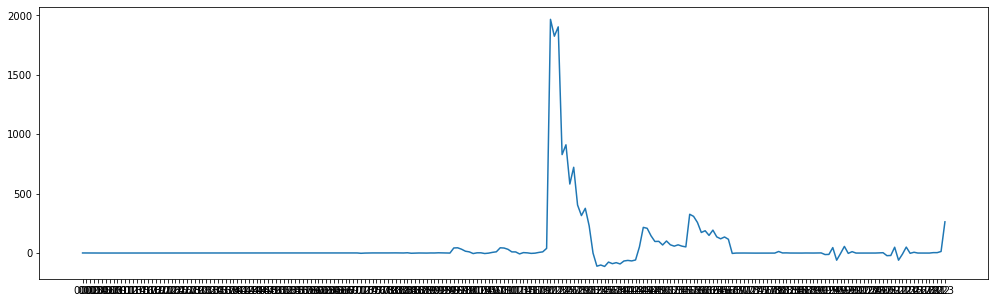

In [18]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x)

### 3.2 Features like MFCCs are discriminant

((2000, 2), (2000,))

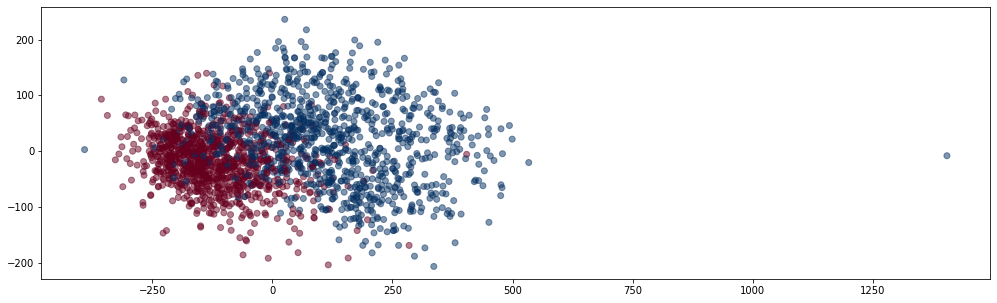

In [19]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [48]:
AUDIO_DIR = "/mnt/d/deep-music-cbr/data/fma_large/"
filename = utils.get_audio_path(AUDIO_DIR, 238) # Doesn't work correctly, glitchy

print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /mnt/d/deep-music-cbr/data/fma_large/000/000238.mp3


/home/elliot/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.98s, 1321967 samples


(1321967,) 44100


(-1.0, 1.0)

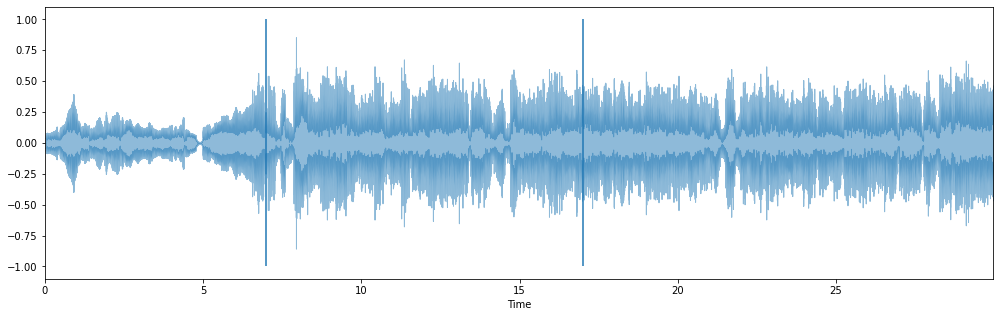

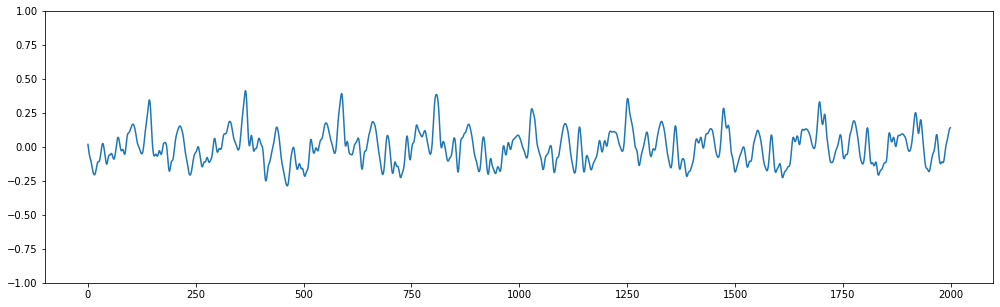

In [49]:
print(x.shape, sr)
librosa.display.waveplot(x, sr=sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

/home/elliot/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/elliot/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


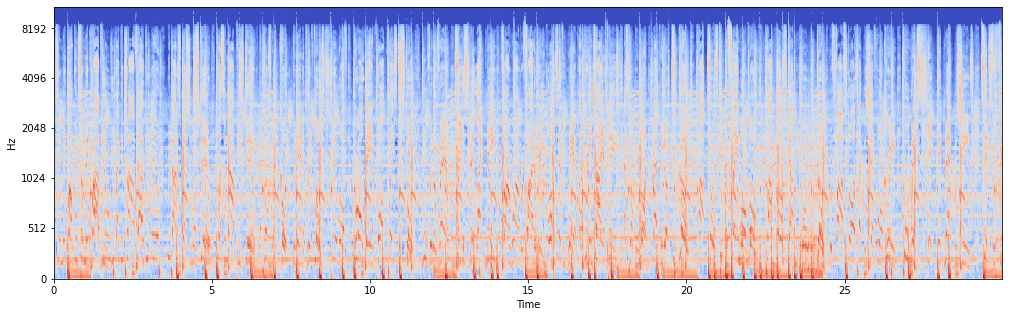

In [47]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')

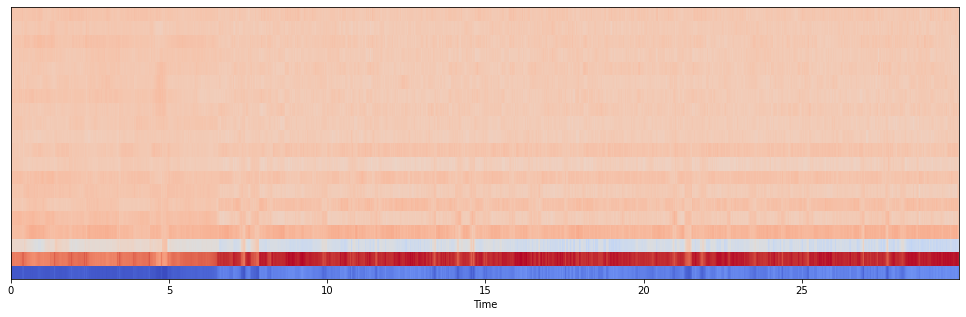

In [44]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

In [31]:
## 5 Genre classification

(1323119,) 44100


(-1.0, 1.0)

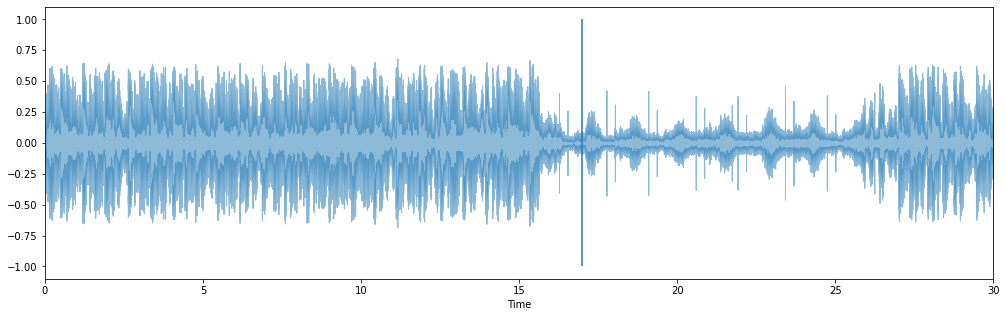

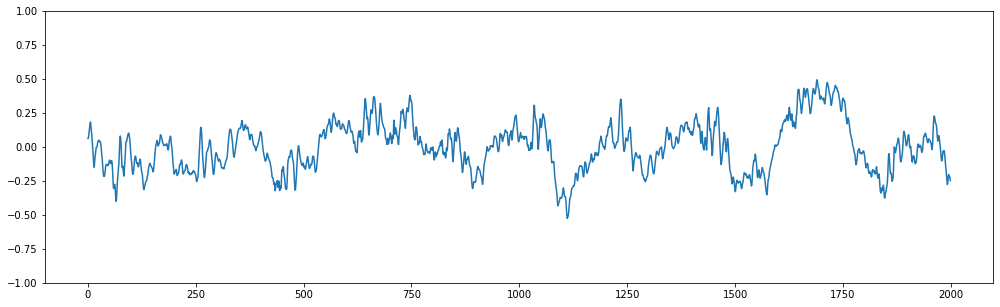

In [32]:
print(x.shape, sr)
librosa.display.waveplot(x, sr=sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

/home/elliot/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/elliot/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


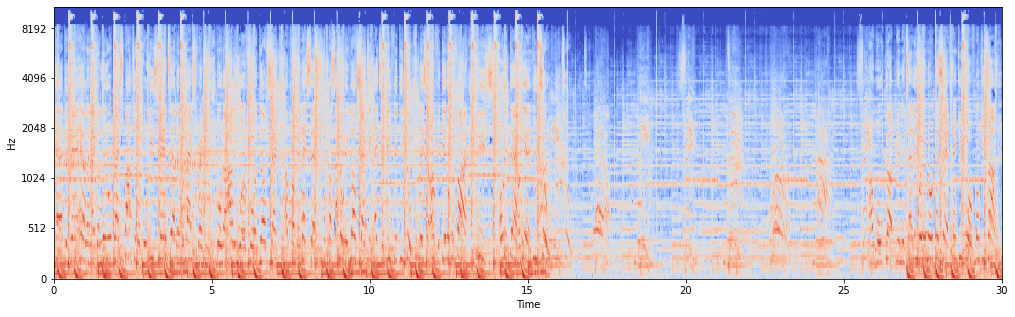

In [33]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')

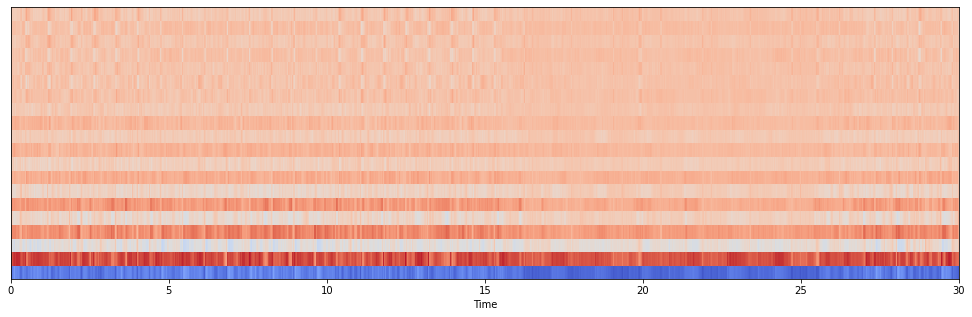

In [34]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

## 5 Genre classification

### 5.1 From features

In [18]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [19]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


### 5.2 From audio